In [1]:
%pip install pytesseract

In [2]:
%pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [3]:
%pip install mplcursors

In [4]:
%pip install easyocr

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from PIL import Image
from scipy import ndimage
from skimage import filters, morphology, measure
from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


In [6]:
image_path = "/content/drive/MyDrive/test_cases/test_pic_C_list.jpeg"

In [7]:


def preprocess_text_image(image, debug=False):
    """
    Comprehensive preprocessing function for text detection and OCR.

    Args:
        image: PIL Image or numpy array (grayscale or RGB)
        debug: bool, if True shows intermediate steps

    Returns:
        PIL Image: Preprocessed binary image optimized for text detection
    """

    # Convert PIL Image to numpy array if needed
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = np.array(image, dtype=np.uint8)

    # Ensure proper data type
    img_array = img_array.astype(np.uint8)

    # Convert to grayscale if RGB
    if len(img_array.shape) == 3:
        gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_array.copy()

    # Ensure uint8 type
    gray = gray.astype(np.uint8)
    original_gray = gray.copy()

    # Step 1: Noise reduction with bilateral filter (preserves edges)
    denoised = cv2.bilateralFilter(gray, 9, 75, 75)

    # Step 2: Contrast enhancement with CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)

    # Step 3: Deskewing (rotation correction)
    def detect_skew_angle(image):
        # Use Hough Line Transform to detect dominant angle
        edges = cv2.Canny(image, 50, 150, apertureSize=3)
        lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)

        if lines is not None:
            angles = []
            for rho, theta in lines[:, 0]:
                angle = theta * 180 / np.pi
                # Focus on near-horizontal lines
                if 85 < angle < 95 or -5 < angle < 5:
                    angles.append(angle if angle < 45 else angle - 90)

            if angles:
                return np.median(angles)
        return 0

    skew_angle = detect_skew_angle(enhanced)
    if abs(skew_angle) > 0.5:  # Only correct if angle is significant
        center = (enhanced.shape[1] // 2, enhanced.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
        deskewed = cv2.warpAffine(enhanced, rotation_matrix,
                                 (enhanced.shape[1], enhanced.shape[0]),
                                 flags=cv2.INTER_CUBIC,
                                 borderMode=cv2.BORDER_REPLICATE)
    else:
        deskewed = enhanced

    # Step 4: Advanced binarization using adaptive thresholding
    # Try multiple methods and combine

    # Method 1: Otsu's thresholding
    _, otsu_binary = cv2.threshold(deskewed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Method 2: Adaptive Gaussian thresholding
    adaptive_gaussian = cv2.adaptiveThreshold(deskewed, 255,
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)

    # Method 3: Adaptive Mean thresholding
    adaptive_mean = cv2.adaptiveThreshold(deskewed, 255,
                                        cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY, 15, 3)

    # Combine methods using weighted average
    combined = cv2.addWeighted(otsu_binary, 0.4, adaptive_gaussian, 0.3, 0)
    combined = cv2.addWeighted(combined, 1.0, adaptive_mean, 0.3, 0)
    _, combined_binary =_, otsu_binary #cv2.threshold(combined, 127, 255, cv2.THRESH_BINARY)

    # Step 5: Morphological operations to clean up text
    # Create kernels for different operations
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    kernel_medium = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
    kernel_line = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))

    # Remove small noise
    cleaned1 = cv2.morphologyEx(combined_binary, cv2.MORPH_OPEN, kernel_small)

    # Connect broken characters
    cleaned2 = cv2.morphologyEx(cleaned1, cv2.MORPH_CLOSE, kernel_medium)

    # Fill small gaps in vertical strokes
    cleaned = combined_binary#cv2.morphologyEx(cleaned1, cv2.MORPH_CLOSE, kernel_line)
    #until here works fine
    # Step 6: Remove small connected components (noise)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        255 - cleaned, connectivity=8)

    # Calculate size threshold based on image dimensions
    min_component_size = max(10, (cleaned.shape[0] * cleaned.shape[1]) // 5000)

    # Create mask for components to keep
    mask = np.zeros_like(cleaned)
    for i in range(1, num_labels):  # Skip background (label 0)
        if stats[i, cv2.CC_STAT_AREA] > min_component_size:
            mask[labels == i] = 255

    # Apply mask (invert because we're working with white text on black background internally)
    final_binary = 255 - mask

    # Step 7: Final cleanup - ensure proper contrast
    final_binary = np.array(cleaned, dtype=np.uint8)
    _, final_binary = cv2.threshold(final_binary, 127, 255, cv2.THRESH_BINARY)

    # Debug visualization
    if debug:
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.ravel()

        images = [
            (original_gray, 'Original'),
            (denoised, 'Denoised'),
            (enhanced, 'CLAHE Enhanced'),
            (deskewed, 'Deskewed'),
            (otsu_binary, 'Otsu Binary'),
            (adaptive_gaussian, 'Adaptive Gaussian'),
            (combined_binary, 'Combined Binary'),
            (final_binary, 'Final Result')
        ]

        for i, (img, title) in enumerate(images):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(title)
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Detected skew angle: {skew_angle:.2f} degrees")
        print(f"Minimum component size threshold: {min_component_size} pixels")
        print(f"Removed {num_labels - 1 - np.sum(np.unique(mask) == 255)} small components")

    # Convert back to PIL Image
    return final_binary


def preprocess_for_ocr(image, line_height=127,target_height=None, debug=False):
    """
    Specialized preprocessing for OCR with optional resizing.

    Args:
        image: PIL Image or numpy array
        debug: bool, show debug information

    Returns:
        PIL Image: Preprocessed image optimized for OCR
    """
    print("Additional pp")
    # First apply general preprocessing
    processed = preprocess_text_image(image,debug)
    processed_array = np.array(processed)


    if debug:
        print(f"Final image size: {processed_array.shape}")
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(image), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(processed_array, cmap='gray')
        plt.title('Preprocessed for OCR')
        plt.axis('off')
        plt.show()

    return processed_array



In [8]:
def read_with_easyocr(image_path):
  import cv2
  import easyocr
  import matplotlib.pyplot as plt
  # Initialize EasyOCR with English
  reader = easyocr.Reader(['en'])

  # Load the image
  #[LOG] adding preprocessing didnt improve the detection
  image = preprocess_for_ocr(cv2.imread(image_path),False)

  # Using easyocr for segmentation
  results = reader.readtext(image, detail=1)

  lines = []
  for (bbox, text, conf) in results:
      (top_left, top_right, bottom_right, bottom_left) = bbox
      x_min = int(min(top_left[0], bottom_left[0]))
      y_min = int(min(top_left[1], top_right[1]))
      x_max = int(max(bottom_right[0], top_right[0]))
      y_max = int(max(bottom_right[1], bottom_left[1]))

      line_img = image[y_min:y_max, x_min:x_max]
      lines.append((line_img, text))
  print("Detected ", len(lines), " lines.")
  # Display segmented lines
  for i, (img, text) in enumerate(lines):
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.title(f'Line {i+1}: {text}')
      plt.axis('off')
      plt.show()

  words = [ word for (image,word) in lines]

  return lines

In [9]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

def detect_words_transformers(lines):
  processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
  model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

  detected_ocr_words = []
  for (img, index) in lines:


    if len(img.shape) == 2 or img.shape[2] == 1:
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    pixel_values = processor(img, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    detected_ocr_words.append(generated_text)
  return detected_ocr_words

In [10]:
def post_process_detections(text):
    import string
    # Remove punctuation and spaces, convert to lowercase
    translator = str.maketrans('', '', string.punctuation + ' ')
    return text.translate(translator).lower()

In [11]:
import nltk
from nltk.corpus import words

nltk.download('words')
word_list = set(words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteAdditional pp
Detected  18  lines.


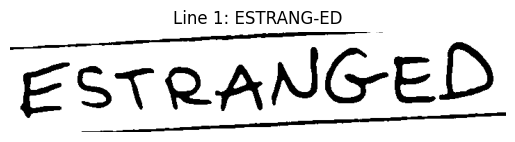

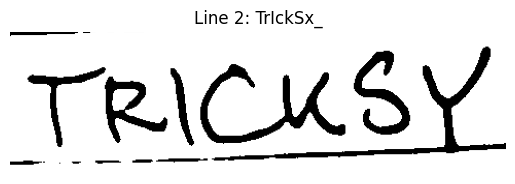

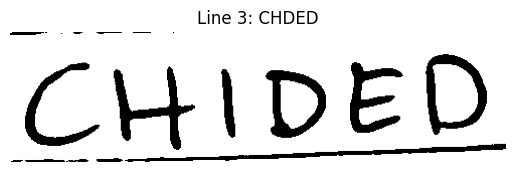

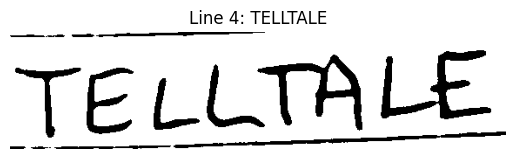

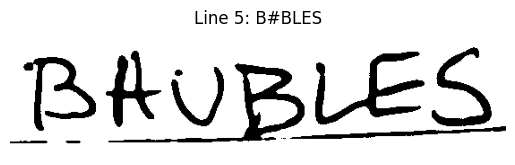

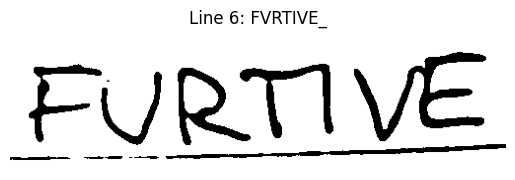

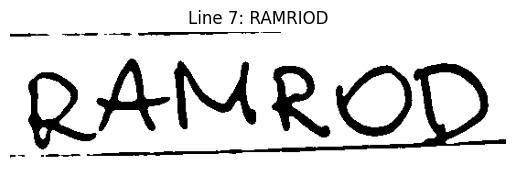

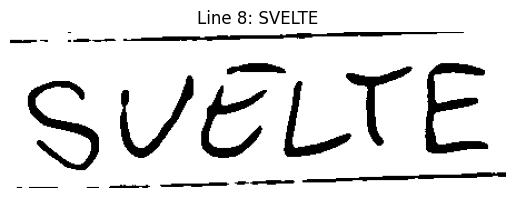

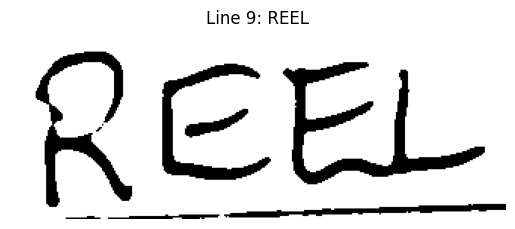

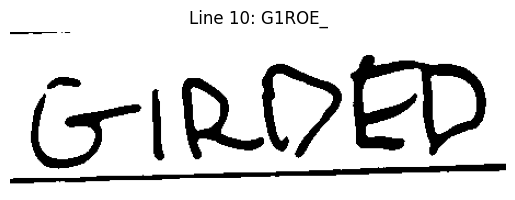

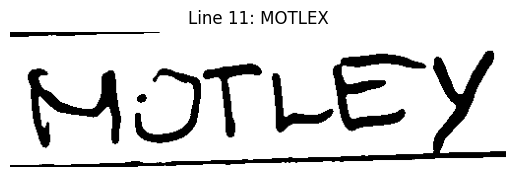

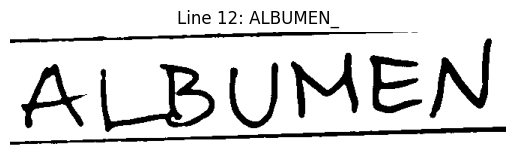

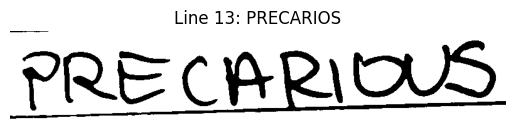

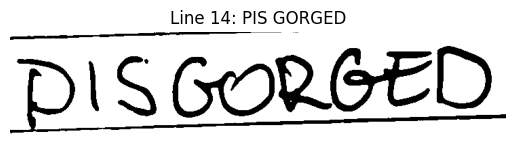

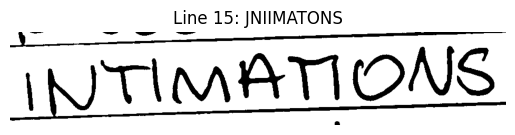

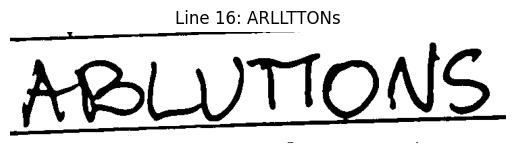

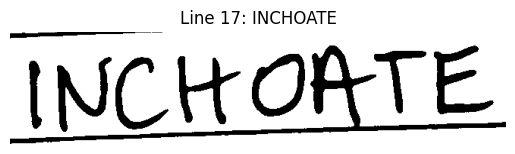

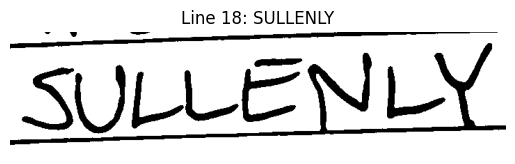

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
lines = read_with_easyocr(image_path)
words_raw = detect_words_transformers(lines)
words = [post_process_detections(word) for word in words_raw]

In [13]:
words = [post_process_detections(word) for word in words_raw]

In [14]:
words

['estranged',
 'tricksy',
 'chided',
 'telltale',
 'bhubles',
 'furtive',
 'ramrod',
 'svelte',
 'reel',
 'girded',
 'mitley',
 'albumen',
 'precarious',
 'pisgorged',
 'intimations',
 'ablutions',
 'inchoate',
 'sullenly']

In [18]:
from huggingface_hub import login
login()

In [16]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load a small model with no login needed
model_name =  "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # or "EleutherAI/gpt-neo-125M"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [17]:
system_message = '''You are a correction software. Users will provide you with a list of words detected by visual detection software.
    Some of them might be incorrect. Using your language resource you must assess weather a word exist or not and suggest a plausible alternative in case it seems faulty.
    Do not write any methods only reason about them.
    Additionally, the context is that the words come from a book with sophisticated language.\n\n'''


prompt = f"<|system|>\n{system_message}\n<|user|>\nThis is the list of words {words}\n<|assistant|>\n"

# Tokenize and generate
inputs = tokenizer(prompt, return_tensors="pt")
output = model.generate(
    **inputs,
    max_new_tokens=500,
    do_sample=True,
    temperature=0.7,
    top_p=0.95,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
response = tokenizer.decode(output[0], skip_special_tokens=True)
print(response)

<|system|>
You are a correction software. Users will provide you with a list of words detected by visual detection software.
    Some of them might be incorrect. Using your language resource you must assess weather a word exist or not and suggest a plausible alternative in case it seems faulty.
    Do not write any methods only reason about them.
    Additionally, the context is that the words come from a book with sophisticated language.


<|user|>
This is the list of words ['estranged', 'tricksy', 'chided', 'telltale', 'bhubles', 'furtive', 'ramrod', 'svelte', 'reel', 'girded', 'mitley', 'albumen', 'precarious', 'pisgorged', 'intimations', 'ablutions', 'inchoate', 'sullenly']
<|assistant|>
1. "Estranged" is correct. It means separated or divorced from someone or something.
2. "Tricksy" is an adjective that describes a person who is clever or deceitful.
3. "Chided" is a verb that means to criticize or speak harshly to someone.
4. "Telltale" is a noun that means an unusual or marked si